In [1]:
import util
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json

fig_size = (11, 9)

data = util.read_pickle_file('./output/cleaned_data.pkl')

In [2]:
def aggregate_region_data_to_df(data):
    """
     Description: Aggregate the data from all the keys in the dictionary
    :param data: dictionary object with key as the region and value being the dataframe
    :return: dataframe
    """
    
    return pd.concat([data[region] for region in data], axis=0)
        
    
df = aggregate_region_data_to_df(data)
numerical_cols = ['views', 'likes', 'dislikes', 'comment_count']
categorical_cols = ['category_id']
textual_cols = ['title', 'channel_title', 'description', 'tags']
date_cols = ['publish_time', 'trending_date']

## Statistical information of numerical variables

In [3]:
df[numerical_cols].describe()

,views,likes,dislikes,comment_count
count,2.396620e+05,2.396620e+05,2.396620e+05,2.396620e+05
mean,1.898465e+06,5.218776e+04,2.849046e+03,5.632043e+03
std,8.746280e+06,1.950500e+05,2.703692e+04,2.951592e+04
min,2.230000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.385125e+04,1.277000e+03,7.300000e+01,1.760000e+02
50%,3.082685e+05,6.522000e+03,2.960000e+02,7.910000e+02
75%,1.041631e+06,2.895575e+04,1.126000e+03,3.043000e+03
max,4.245389e+08,5.613827e+06,1.944971e+06,1.626501e+06


## Correlation among different variables

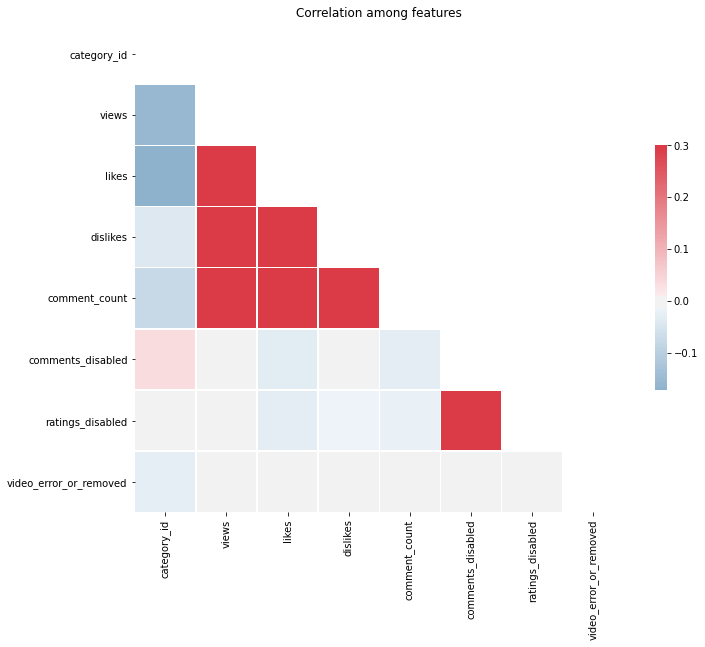

In [4]:
#Calculate the correlation amond different features
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=fig_size)
plt.title('Correlation among features')
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

From the above visualization it can be seen that there is positive correlation between view, likes, dislikes, views and comment_count


## Histogram of variables

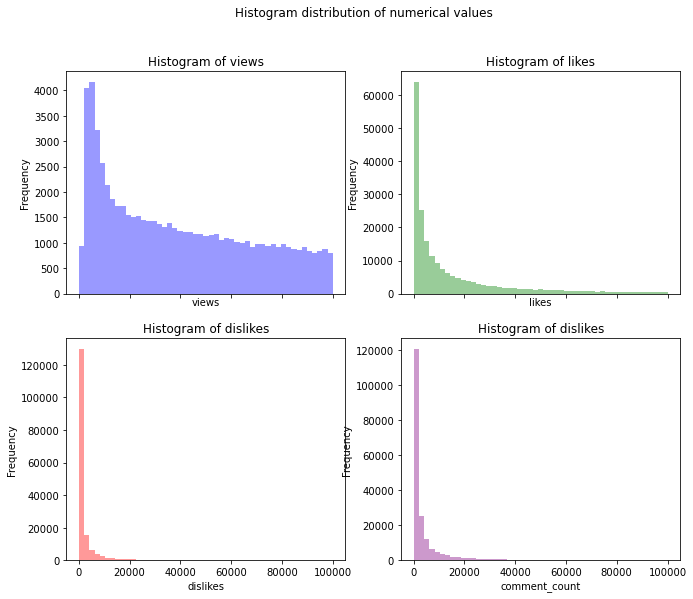

In [5]:
def visualize_histogram(data):
    """
     Description:A function to visulize histograms usin
    :param data: pandas dataframe
    :param col: the column name whose histogram needs to be visualized
    :return: dataframe
    """
    fig, axes = plt.subplots(2, 2, sharex=True, figsize=(fig_size))
    fig.suptitle('Histogram distribution of numerical values')
    
    sns.distplot(df['views'], bins=np.linspace(1e2, 1e5, 50), kde=False, color='blue', ax=axes[0][0])
    axes[0][0].set_title('Histogram of views')
    axes[0][0].set_xlabel('views')
    axes[0][0].set_ylabel('Frequency')
    
    sns.distplot(df['likes'], bins=np.linspace(1e2, 1e5, 50), kde=False, color='green', ax=axes[0][1])
    axes[0][1].set_title('Histogram of likes')
    axes[0][1].set_xlabel('likes')
    axes[0][1].set_ylabel('Frequency')
    
    sns.distplot(df['dislikes'], bins=np.linspace(1e2, 1e5, 50), kde=False, color='red', ax=axes[1][0])
    axes[1][0].set_title('Histogram of dislikes')
    axes[1][0].set_xlabel('dislikes')
    axes[1][0].set_ylabel('Frequency')
    
    sns.distplot(df['comment_count'], bins=np.linspace(1e2, 1e5, 50), kde=False, color='purple', ax=axes[1][1])
    axes[1][1].set_title('Histogram of dislikes')
    axes[1][1].set_xlabel('comment_count')
    axes[1][1].set_ylabel('Frequency')

visualize_histogram(df)

## Barplot of category count

Text(0.5, 1.0, 'Distribution of Categories')

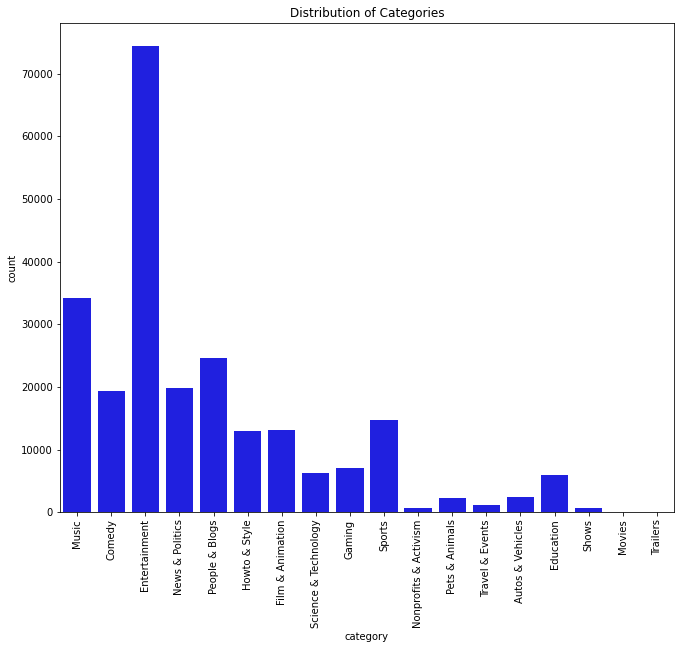

In [6]:
category_data = json.loads(open('./data/US_category_id.json').read())
cateogry_id_title_dict = dict()
for item in category_data['items']:
    cateogry_id_title_dict[int(item['id'])] = item['snippet']['title'] 
df['category'] = df.apply (lambda row: cateogry_id_title_dict[int(row['category_id'])], axis=1)

fig, ax = plt.subplots(figsize=fig_size)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.countplot(x='category', data=df, color="blue")
plt.title('Distribution of Categories')

## Number of videos in each region

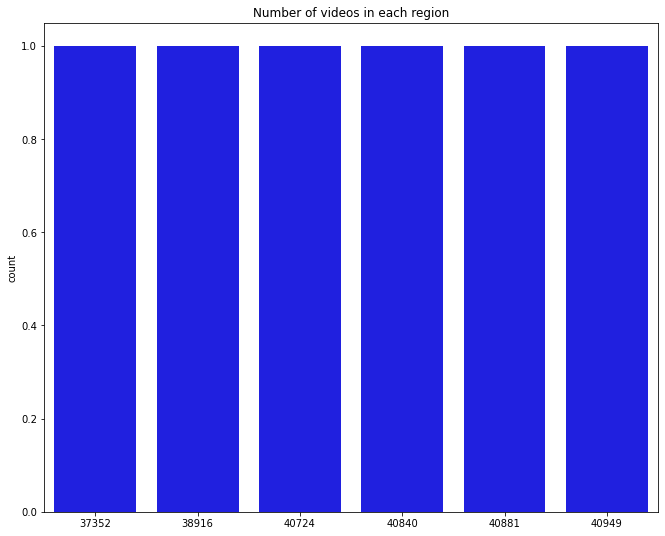

In [7]:
fig, ax = plt.subplots(figsize=fig_size)
plt.title('Number of videos in each region')
sns.countplot(x=[data[key].shape[0] for key in data], color="blue")

## Which day of the week are trending videos published


Text(0.5, 1.0, 'When are trending videos published')

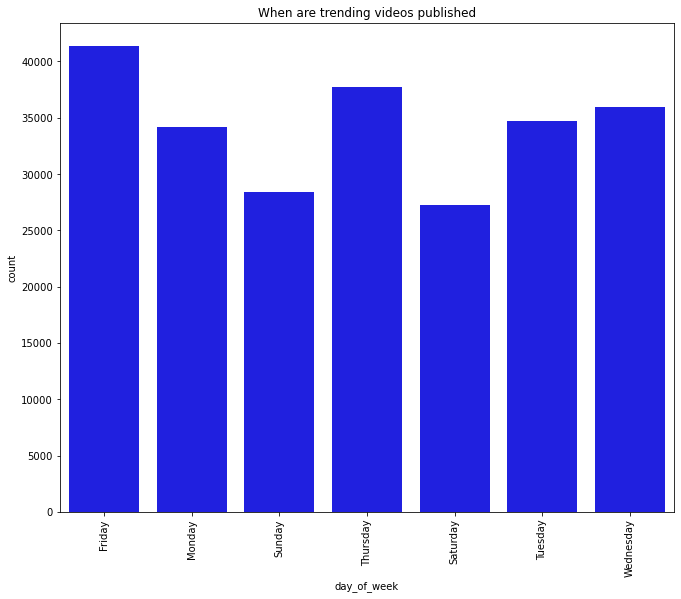

In [40]:
df['publish_time'] = pd.to_datetime(df['publish_time'], infer_datetime_format=True).dt.tz_localize(None)  
df['day_of_week'] = df.apply(lambda row: row['publish_time'].strftime('%A'), axis=1)

fig, ax = plt.subplots(figsize=fig_size)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.countplot(x='day_of_week', data=df, color="blue")
plt.title('When are trending videos published')

## Number of hours it takes for a video to go trending

Text(0, 0.5, 'Number of trending videos')

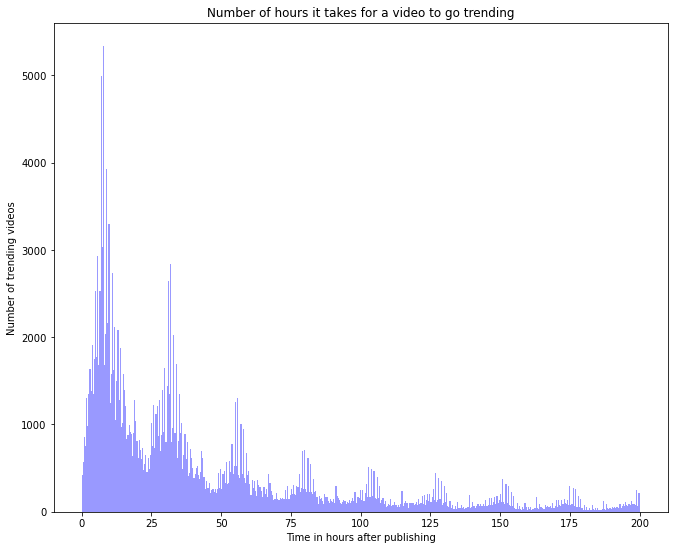

In [42]:
trending_time = pd.to_datetime(df[date_cols[1]], format="%y.%d.%m") 
number_of_hours = (trending_time - publish_time) / np.timedelta64(1, 'h')
fig, ax = plt.subplots(figsize=fig_size)
plt.title('Number of hours it takes for a video to go trending')
sns.distplot(number_of_hours, bins=np.linspace(0, 200, 500), kde=False, color='blue', ax=ax)
ax.set_xlabel("Time in hours after publishing")
ax.set_ylabel("Number of trending videos")

## Most common tags that are trending

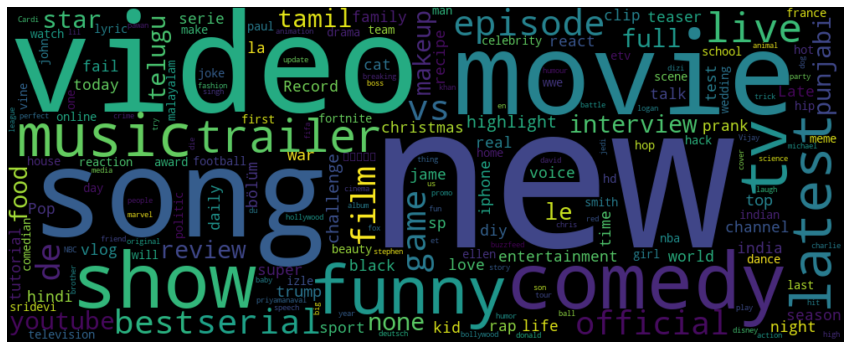

In [18]:
from collections import Counter 
from wordcloud import WordCloud

videos_tags = list(df['tags'].apply(lambda x: x.replace('"', '').split("|")))
tags = [video_tag for video_tags in videos_tags for video_tag in video_tags]
Counter(tags).most_common(25)
wc = WordCloud(width=1000, height=400, collocations=False).generate(" ".join(tags))
plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

## How are the statistics of videos with comments and ratings disabled compared to not disabled

In [48]:
df.groupby('ratings_disabled').describe()[numerical_cols]

views                                              \
                     count          mean           std    min      25%   
ratings_disabled                                                         
False             236785.0  1.902846e+06  8.758516e+06  223.0  85438.0   
True                2877.0  1.537886e+06  7.665335e+06  527.0  20200.0   

                                                       likes                \
                       50%        75%          max     count          mean   
ratings_disabled                                                             
False             311777.0  1049769.0  424538912.0  236785.0  52821.856613   
True               90984.0   399510.0   62338362.0    2877.0      0.000000   

                  ... dislikes            comment_count               \
                  ...      75%        max         count         mean   
ratings_disabled  ...                                                  
False             ...   1148.0  1944971.0      236785.0  5695.294875   
True              ...      0.0        0.0        2877.0   426.263121   

                                                                      
                           std  min    25%    50%     75%        max  
ratings_disabled                                                      
False             29688.450732  0.0  185.0  810.0  3100.0  1626501.0  
True               1749.236268  0.0    0.0    5.0   147.0    30391.0  

[2 rows x 32 columns]

In [49]:
df.groupby('comments_disabled').describe()[numerical_cols]

views                                               \
                      count          mean           std    min       25%   
comments_disabled                                                          
False              234626.0  1.908266e+06  8.796023e+06  223.0  85584.50   
True                 5036.0  1.441839e+06  5.969661e+06  527.0  29011.25   

                                                         likes                \
                        50%         75%          max     count          mean   
comments_disabled                                                              
False              310781.5  1046223.75  424538912.0  234626.0  53096.474201   
True               192542.0   824848.75   62338362.0    5036.0   9851.064734   

                   ... dislikes            comment_count               \
                   ...      75%        max         count         mean   
comments_disabled  ...                                                  
False              ...   1137.0  1944971.0      234626.0  5752.929155   
True               ...    577.0    75955.0        5036.0     0.000000   

                                                                       
                            std  min    25%    50%     75%        max  
comments_disabled                                                      
False              29819.341275  0.0  198.0  834.0  3160.0  1626501.0  
True                   0.000000  0.0    0.0    0.0     0.0        0.0  

[2 rows x 32 columns]